# Part 3 - Analysing climate data and correlations with land use change

## Notebook outline: 

This notebook provides the functions used to extract climate data, as well as outlining analysis conducted to assess correlations between climate variables and land use change. Finally, it outlines analysis of yearly mean difference in both climate variables and forest percentage compared to the mean of 1985-1999.


The analysis requires the following libraries:

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import seaborn as sb 

import os
from scipy import stats
from scipy.spatial import cKDTree

import urllib.request
import datetime as dt

import netCDF4
from netCDF4 import Dataset, num2date

from matplotlib import pyplot as plt
%matplotlib inline

import cmocean


Function:


This function extracts climate data from TerraClimate urls based on, latitude, logitude and year. It also calculates the mean temperature from maximum and minimum datasets. This was used for further analysis


In [2]:
#Urls that contain the climate data

tmax_url = "http://thredds.northwestknowledge.net/thredds/dodsC/agg_terraclimate_tmax_1958_CurrentYear_GLOBE.nc" #maximum temperature
tmin_url = "http://thredds.northwestknowledge.net/thredds/dodsC/agg_terraclimate_tmin_1958_CurrentYear_GLOBE.nc" #minimum temperature
ppt_url = "http://thredds.northwestknowledge.net/thredds/dodsC/agg_terraclimate_ppt_1958_CurrentYear_GLOBE.nc" #precipitation
aet_url = "http://thredds.northwestknowledge.net/thredds/dodsC/agg_terraclimate_aet_1958_CurrentYear_GLOBE.nc" #evapotranspiration


def climate_datasets(time_start, time_end, lon_start, lon_end, lat_start, lat_end):
   
    """
    This function (i) extracts climate data for a given time period and particular set of coordinates,
    (ii) calculates mean temp, (iii) combines all datasets into one dataframe
    
    Variables:
    time_start = first year of climate data
    time_end = final year of climate data
    lon_start = beginning longitude coordinate
    lon_end = end longitude coordinate
    lat_start = beginning latitidue coordinate
    lat_end = end latitude coordinate

    Datasources:
    
    Climate datasources were extracted from the aggregated Terraclimate databased: http://thredds.northwestknowledge.net/thredds/terraclimate_aggregated.html
    """

    #open datasets from urls
    ds_tmax = xr.open_dataset(tmax_url, drop_variables=['crs'])
    ds_tmin = xr.open_dataset(tmin_url, drop_variables=['crs'])
    ds_ppt = xr.open_dataset(ppt_url, drop_variables=['crs'])
    ds_aet = xr.open_dataset(aet_url, drop_variables=['crs'])
   
    # Combine the datasets by their coordinates (lat,lon and time)
    climate_ds = xr.combine_by_coords([ds_tmax, ds_tmin, ds_ppt, ds_aet], combine_attrs='override')

    # Slice the data based on time, latitude, and longitude
    climate_ds = climate_ds.sel(time=slice(time_start, time_end), lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
    
    #Calculate the mean for the entire selected region
    climate_ds = climate_ds.mean(['lon', 'lat'])

    #calculate the mean temp from the tmax and tmin 
    temp_ds = xr.combine_by_coords([ds_tmax, ds_tmin])
    temp_ds = temp_ds.sel(time=slice(time_start, time_end), lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
    v1_tmax = temp_ds['tmax']
    v2_tmin = temp_ds['tmin']
    mean_temp = ((v1_tmax + v2_tmin)/2).mean(['lon', 'lat'])
    
    #rename mean temp ds to convert to dataframe
    mean_temp = mean_temp.rename('mean temp')

    #convert datasets to dataframes
    climate_df = climate_ds.to_dataframe()
    mean_temp_df = mean_temp.to_dataframe()

    #join the dataframes
    combined_df = climate_df.join(mean_temp_df)

    yr_mean = combined_df.groupby('time').mean()#.reset_index()
    yr_mean = yr_mean.resample('1Y').mean()

    return yr_mean

The following sites were selected:

In [3]:
Site_1 = climate_datasets('1985-01', '2022-12', -48,-46, -3, -5)
Site_2 = climate_datasets('1985-01', '2022-12', -52,-50, -2, -4)
Site_3 = climate_datasets('1985-01', '2022-12', -65,-63, -8, -10)
Site_4 = climate_datasets('1985-01', '2022-12', -58, -56, -10, -12)
Control_site = climate_datasets('1985-01', '2022-12', -69, -67, -1, -3)

#Climate data for each site was saved to csv
Site_1.to_csv('Site_1_climate_ds.csv')
Site_2.to_csv('Site_2_climate_ds.csv')
Site_3.to_csv('Site_3_climate_ds.csv')
Site_4.to_csv('Site_4_climate_ds.csv')
Control_site.to_csv('Control_site_climate_ds.csv')

Function:

This function was used to extract monthly data from the downloaded albedo dataset. Due to the large file size the data was downloaded to a computer and then coded. As such, the following code does not work without the downloaded data.

In [0]:
#extract data for albedo

https://disc.gsfc.nasa.gov/datasets/M2TMNXRAD_5.12.4/summary?keywords=%22MERRA-2%22%20albedo

months = ['01','02','03','04','05','06','07','08','09','10','11','12']

def getYearlyAlbedo(year, lon1, lon2, lat1, lat2):
    meanAlbedo = []
    for k in range(len(months)):
        if year < 2011:
            fname = 'NASA/MERRA2_300.tavgM_2d_rad_Nx.'+str(year)+months[k]+'.nc4'
        else:
            fname = 'NASA/MERRA2_400.tavgM_2d_rad_Nx.'+str(year)+months[k]+'.nc4'
        ds = xr.open_dataset(fname).sel(lon=slice(lon1,lon2), lat=slice(lat1,lat2))
        meanAlbedo.append(ds.isel(time=0).ALBEDO.mean().values+0.)
    
    # initialize data of lists. 
    data = {'months': np.arange(12)+1, 
            str(year): meanAlbedo} 


    return pd.DataFrame(data) 
for y in range(2002,2022):
    albedo = getYearlyAlbedo(y, -69, -67, -3, -1)

    if y == 2002:
        albedo_df = albedo.copy()
    else:
        albedo_df[str(y)] = albedo[str(y)]
        
albedo_df.to_csv('albedo_monthly_mean_control_site.csv')
for y in range(2002,2022):
    albedo = getYearlyAlbedo(y, -48, -46, -5, -3)

    if y == 2002:
        albedo_df1 = albedo.copy()
    else:
        albedo_df1[str(y)] = albedo[str(y)]
        
albedo_df1.to_csv('albedo_monthly_mean_site1.csv')
for y in range(2002,2022):
    albedo = getYearlyAlbedo(y, -52, -50, -4, -2)

    if y == 2002:
        albedo_df2 = albedo.copy()
    else:
        albedo_df2[str(y)] = albedo[str(y)]
        
albedo_df2.to_csv('albedo_monthly_mean_site2.csv')

for y in range(2002,2022):
    albedo = getYearlyAlbedo(y, -65, -63, -10, -8)

    if y == 2002:
        albedo_df3 = albedo.copy()
    else:
        albedo_df3[str(y)] = albedo[str(y)]
        
albedo_df3.to_csv('albedo_monthly_mean_site3.csv')

for y in range(2002,2022):
    albedo = getYearlyAlbedo(y, -58, -56, -10, -12)

    if y == 2002:
        albedo_df4 = albedo.copy()
    else:
        albedo_df4[str(y)] = albedo[str(y)]
        
albedo_df4.to_csv('albedo_monthly_mean_site4.csv')

The following code was used to plot the monthly albedo per site

In [4]:
#Monthly albedo csv was read
df_control_og = pd.read_csv('albedo_monthly_mean_control_site.csv')
df_site1_og = pd.read_csv('albedo_monthly_mean_site1.csv')
df_site2_og = pd.read_csv('albedo_monthly_mean_site2.csv')
df_site3_og = pd.read_csv('albedo_monthly_mean_site3.csv')
df_site4_og = pd.read_csv('albedo_monthly_mean_site4.csv')

In [5]:
#Remove rid of months column and calculate yearly means per site
df_control = df_control_og.iloc[:,2:]
df_control.index = df_control.index + 1
df_control_yearly = df_control.mean()

df_site1 = df_site1_og.iloc[:,2:]
df_site1.index = df_site1.index + 1
df_site1_yearly = df_site1.mean()

df_site2 = df_site2_og.iloc[:,2:]
df_site2.index = df_site2.index + 1
df_site2_yearly = df_site2.mean()

df_site3 = df_site3_og.iloc[:,2:]
df_site3.index = df_site3.index + 1
df_site3_yearly = df_site3.mean()

df_site4 = df_site4_og.iloc[:,2:]
df_site4.index = df_site4.index + 1
df_site4_yearly = df_site4.mean()

In [6]:
#manipulate dataframes to link albedo values to dates

df_control_bymonth = pd.DataFrame(df_control.values.ravel(), columns=['Albedo'])
df_control_bymonth.index = pd.date_range(start='2002-01', end='2023-01', freq='M')

df_site1_bymonth = pd.DataFrame(df_site1.values.ravel(), columns=['Albedo'])
df_site1_bymonth.index = pd.date_range(start='2002-01', end='2023-01', freq='M')

df_site2_bymonth = pd.DataFrame(df_site2.values.ravel(), columns=['Albedo'])
df_site2_bymonth.index = pd.date_range(start='2002-01', end='2023-01', freq='M')

df_site3_bymonth = pd.DataFrame(df_site3.values.ravel(), columns=['Albedo'])
df_site3_bymonth.index = pd.date_range(start='2002-01', end='2023-01', freq='M')

df_site4_bymonth = pd.DataFrame(df_site4.values.ravel(), columns=['Albedo'])
df_site4_bymonth.index = pd.date_range(start='2002-01', end='2023-01', freq='M')

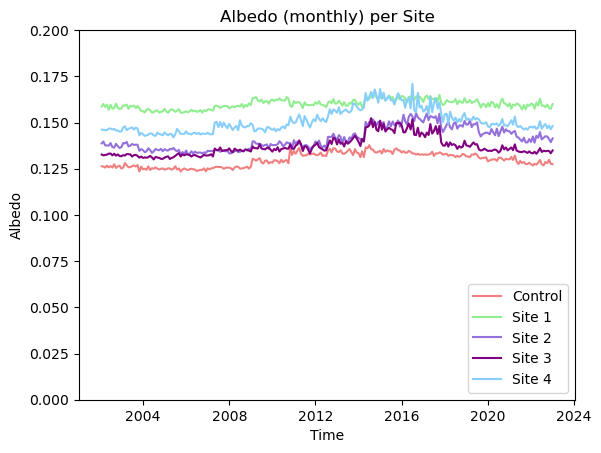

In [7]:
#plot monthly data

fig, ax1 = plt.subplots()
ax1.plot(df_control_bymonth, color = 'lightcoral')
ax1.set_ylim(0, 0.2)
ax1.set_ylabel('Albedo')
ax1.set_xlabel('Time')
ax1.set_title('Albedo (monthly) per Site')

ax2 = ax1
ax2.plot(df_site1_bymonth, color = 'lightgreen')

ax3 = ax1
ax3.plot(df_site2_bymonth, color = 'mediumpurple')

ax4 = ax1
ax4.plot(df_site3_bymonth, color = 'purple')

ax5 = ax1
ax5.plot(df_site4_bymonth, color = 'lightskyblue')

plt.legend(["Control", "Site 1", "Site 2", "Site 3", "Site 4"], loc = 'lower right')

## Correlation matrices

The following code was combines climate, albedo, and vegetation variables for each site and was used to create a correlation matrix to analyse correlations between variables 

In [8]:
#read the csv data file for each site
#Site 1
S1_alb = pd.read_csv("albedo_monthly_mean_site1.csv") #albedo
S1_veg = pd.read_csv("vegetation_analysis_sample_site_perc_Sample Site 1_1985-2022.csv") #vegetation
S1_cli = pd.read_csv("Site_1_climate_ds.csv") #evapotranspiration, temperature and precipitation

#Site 2
S2_alb = pd.read_csv("albedo_monthly_mean_site2.csv")
S2_veg = pd.read_csv("vegetation_analysis_sample_site_perc_Sample Site 2_1985-2022.csv") 
S2_cli = pd.read_csv("Site_2_climate_ds.csv")

#Site 3
S3_alb = pd.read_csv("albedo_monthly_mean_site3.csv")
S3_veg = pd.read_csv("vegetation_analysis_sample_site_perc_Sample Site 3_1985-2022.csv") 
S3_cli = pd.read_csv("Site_3_climate_ds.csv")

#Site 4
S4_alb = pd.read_csv("albedo_monthly_mean_site4.csv")
S4_veg = pd.read_csv("vegetation_analysis_sample_site_perc_Sample Site 4_1985-2022.csv") 
S4_cli = pd.read_csv("Site_4_climate_ds.csv")

#Control Site
CS_alb = pd.read_csv("albedo_monthly_mean_control_site.csv")
CS_veg = pd.read_csv("vegetation_analysis_sample_site_perc_Control Site_1985-2022.csv") 
CS_cli = pd.read_csv("Control_site_climate.csv")

Select the albedo data

In [10]:
#Remove months column and calculate yearly means per site
#Convert albedo data to dataframe
#rename albedo column 
#Save yearly albedo data to csv
#reset the albedo index

#Site 1
S1_alb = S1_alb.iloc[:,2:] #remove month column
S1_alb.index = S1_alb.index + 1
S1_alb = S1_alb.mean() #yearly mean
S1_alb = pd.DataFrame(S1_alb) #convert to dataframe
S1_alb = S1_alb.rename(columns={0: 'albedo'}) #rename albedo column
S1_alb.to_csv('Site_1_albedo_yr.csv') #save to csv
S1_alb = S1_alb.reset_index(drop=True) #reset index
S1_alb.index = range(17, 38)

#Site 2
S2_alb = S2_alb.iloc[:,2:]
S2_alb.index = S2_alb.index + 1
S2_alb = S2_alb.mean()
S2_alb = pd.DataFrame(S2_alb)
S2_alb = S2_alb.rename(columns={0: 'albedo'})
S2_alb.to_csv('Site_2_albedo_yr.csv')
S2_alb = S2_alb.reset_index(drop=True)
S2_alb.index = range(17, 38)

#Site 3
S3_alb = S3_alb.iloc[:,2:]
S3_alb.index = S3_alb.index + 1
S3_alb = S3_alb.mean()
S3_alb = pd.DataFrame(S3_alb)
S3_alb = S3_alb.rename(columns={0: 'albedo'})
S3_alb.to_csv('Site_3_albedo_yr.csv')
S3_alb = S3_alb.reset_index(drop=True)
S3_alb.index = range(17, 38)

#Site 4
S4_alb = S4_alb.iloc[:,2:]
S4_alb.index = S4_alb.index + 1
S4_alb = S4_alb.mean()
S4_alb = pd.DataFrame(S4_alb)
S4_alb = S4_alb.rename(columns={0: 'albedo'})
S4_alb.to_csv('Site_4_albedo_yr.csv')
S4_alb = S4_alb.reset_index(drop=True)
S4_alb.index = range(17, 38)

#Site 5
CS_alb = CS_alb.iloc[:,2:]
CS_alb.index = CS_alb.index + 1
CS_alb = CS_alb.mean()
CS_alb = pd.DataFrame(CS_alb)
CS_alb = CS_alb.rename(columns={0: 'albedo'})
CS_alb.to_csv('Control_site_albedo_yr.csv')
CS_alb = CS_alb.reset_index(drop=True)
CS_alb.index = range(17, 38)

Select the climate data

In [11]:
#Select the climate data from 2002 onward
S1_cli = S1_cli.iloc[17:]
S2_cli = S2_cli.iloc[17:]
S3_cli = S3_cli.iloc[17:]
S4_cli = S4_cli.iloc[17:]
CS_cli = CS_cli.iloc[17:]

Select the forest and pasture data from the vegetation dataset

In [12]:
#Select the forest cover and pasture vegetation columns from the vegetation datasets
#Pivot the vegetation data table to align with albedo and climate dataset

#site 1
S1_veg = S1_veg.iloc[[1, 14], :] #select forest and pasture columns
S1_veg = pd.pivot_table(S1_veg, columns=['Florestal 1.1. Forest Formation', '3.1. Pasture', ]).reset_index() #pivot data
S1_veg = S1_veg.drop('index', axis=1) #drop index
S1_veg = S1_veg.rename(columns={'Florestal 1.1. Forest Formation' :'Forest Formation', '3.1. Pasture': 'Pasture'}) #rename

#site 2
S2_veg = S2_veg.iloc[[1, 14], :]
S2_veg = pd.pivot_table(S2_veg, columns=['Florestal 1.1. Forest Formation', '3.1. Pasture', ]).reset_index()
S2_veg = S2_veg.drop('index', axis=1)
S2_veg = S2_veg.rename(columns={'Florestal 1.1. Forest Formation' :'Forest Formation', '3.1. Pasture': 'Pasture'})

#site 3
S3_veg = S3_veg.iloc[[1, 14], :]
S3_veg = pd.pivot_table(S3_veg, columns=['Florestal 1.1. Forest Formation', '3.1. Pasture', ]).reset_index()
S3_veg = S3_veg.drop('index', axis=1)
S3_veg = S3_veg.rename(columns={'Florestal 1.1. Forest Formation' :'Forest Formation', '3.1. Pasture': 'Pasture'})

#site 4
S4_veg = S4_veg.iloc[[1, 14], :]
S4_veg = pd.pivot_table(S4_veg, columns=['Florestal 1.1. Forest Formation', '3.1. Pasture', ]).reset_index()
S4_veg = S4_veg.drop('index', axis=1)
S4_veg = S4_veg.rename(columns={'Florestal 1.1. Forest Formation' :'Forest Formation', '3.1. Pasture': 'Pasture'}) 

#control site
CS_veg = CS_veg.iloc[[1, 14], :]
CS_veg = pd.pivot_table(CS_veg, columns=['Florestal 1.1. Forest Formation', '3.1. Pasture', ]).reset_index()
CS_veg = CS_veg.drop('index', axis=1)
CS_veg = CS_veg.rename(columns={'Florestal 1.1. Forest Formation' :'Forest Formation', '3.1. Pasture': 'Pasture'}) 

/tmp/ipykernel_49/4264765425.py:6: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  S1_veg = pd.pivot_table(S1_veg, columns=['Florestal 1.1. Forest Formation', '3.1. Pasture', ]).reset_index() #pivot data
/tmp/ipykernel_49/4264765425.py:12: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  S2_veg = pd.pivot_table(S2_veg, columns=['Florestal 1.1. Forest Formation', '3.1. Pasture', ]).reset_index()
/tmp/ipykernel_49/4264765425.py:18: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  S3_veg = pd.pivot_table(S3_veg, columns=['Florestal 1.1. Forest

In [13]:
#Crop the vegetation data to start in 2002
S1_veg = S1_veg.iloc[17:]
S2_veg = S2_veg.iloc[17:]
S3_veg = S3_veg.iloc[17:]
S4_veg = S4_veg.iloc[17:]
CS_veg = CS_veg.iloc[17:]

Combine the albedo, climate, and vegetation datasets

In [14]:
#Combine the climate and vegetation data
combined_df1 = S1_cli.join(S1_veg)
combined_df2 = S2_cli.join(S2_veg)
combined_df3 = S3_cli.join(S3_veg)
combined_df4 = S4_cli.join(S4_veg)
combined_dfCS = CS_cli.join(CS_veg)

In [15]:
#Add the albedo data to the df
combined_df1 = combined_df1.join(S1_alb)
combined_df2 = combined_df2.join(S2_alb)
combined_df3 = combined_df3.join(S3_alb)
combined_df4 = combined_df4.join(S4_alb)
combined_dfCS = combined_dfCS.join(CS_alb)

Plot the correlation matrices

Correlation for Site 1:
                       aet       ppt      tmax      tmin  mean temp   Pasture  \
aet               1.000000 -0.048703 -0.045727 -0.113369  -0.077980  0.119225   
ppt              -0.048703  1.000000 -0.389371 -0.404728  -0.398071  0.294772   
tmax             -0.045727 -0.389371  1.000000  0.985496   0.996755 -0.003644   
tmin             -0.113369 -0.404728  0.985496  1.000000   0.995958  0.001444   
mean temp        -0.077980 -0.398071  0.996755  0.995958   1.000000 -0.001245   
Pasture           0.119225  0.294772 -0.003644  0.001444  -0.001245  1.000000   
Forest Formation  0.171527 -0.148857 -0.436774 -0.436566  -0.438262 -0.461861   
albedo           -0.021744 -0.512234  0.356648  0.349758   0.354674 -0.158282   

                  Forest Formation    albedo  
aet                       0.171527 -0.021744  
ppt                      -0.148857 -0.512234  
tmax                     -0.436774  0.356648  
tmin                     -0.436566  0.349758  
mean temp  

/tmp/ipykernel_49/3338660637.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr()) #print the correlation data for each site
/tmp/ipykernel_49/3338660637.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True) #create a correlation heatmap for each site
/tmp/ipykernel_49/3338660637.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr()) #print the correlation data for each site
/tmp/ipykernel_4

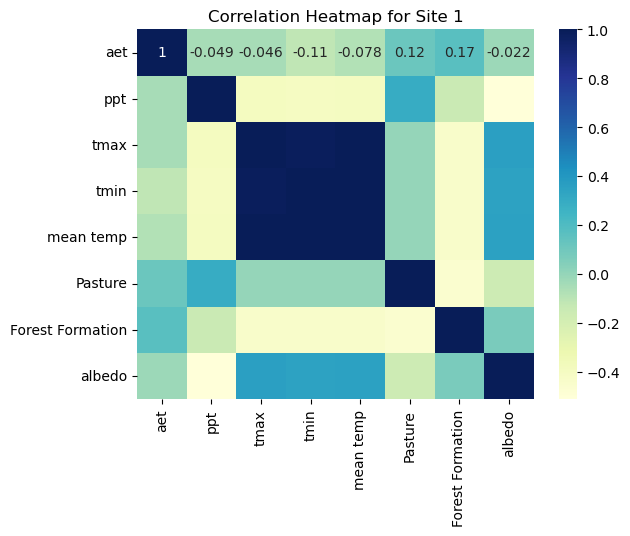

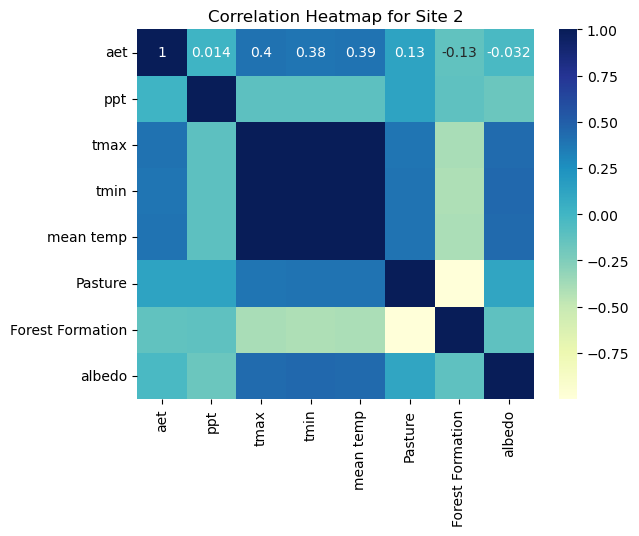

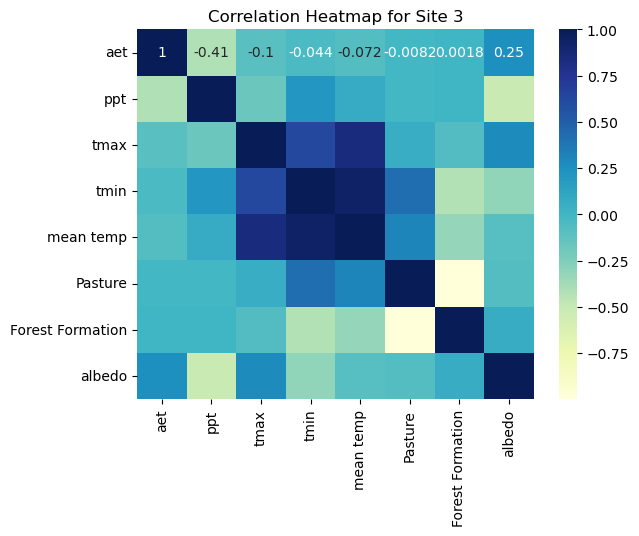

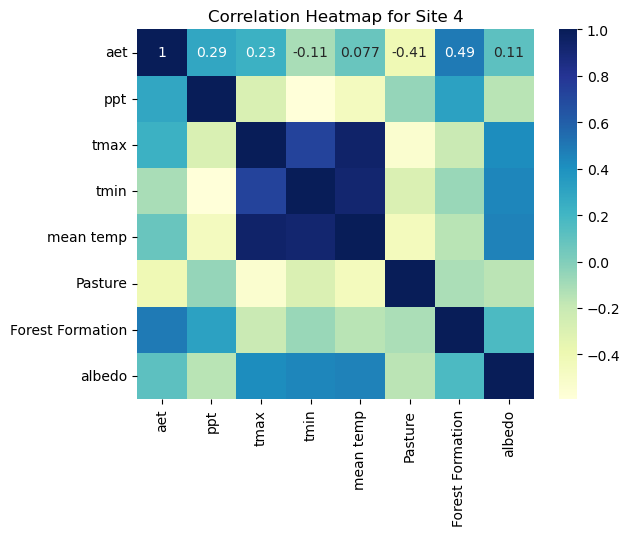

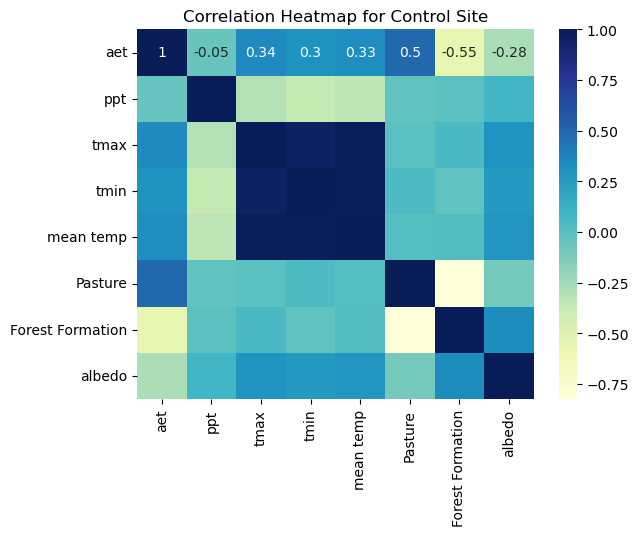

In [16]:
# Plot the correlation matrix for each site
dataframes = [combined_df1, combined_df2, combined_df3, combined_df4, combined_dfCS]
site_names = ['Site 1', 'Site 2', 'Site 3', 'Site 4', 'Control Site']

for site_name, df in zip(site_names, dataframes):
    print(f"Correlation for {site_name}:")
    print(df.corr()) #print the correlation data for each site
    dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True) #create a correlation heatmap for each site
    plt.title(f"Correlation Heatmap for {site_name}")
    plt.savefig(f'correlation_heatmap_{site_name}.png', bbox_inches='tight', dpi=100)
    plt.show()

/tmp/ipykernel_49/2617288155.py:27: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  S2_ax = sb.heatmap(combined_dfCS.corr(), cmap='YlGnBu', linewidths=0.5, annot=True, ax=ax[1])


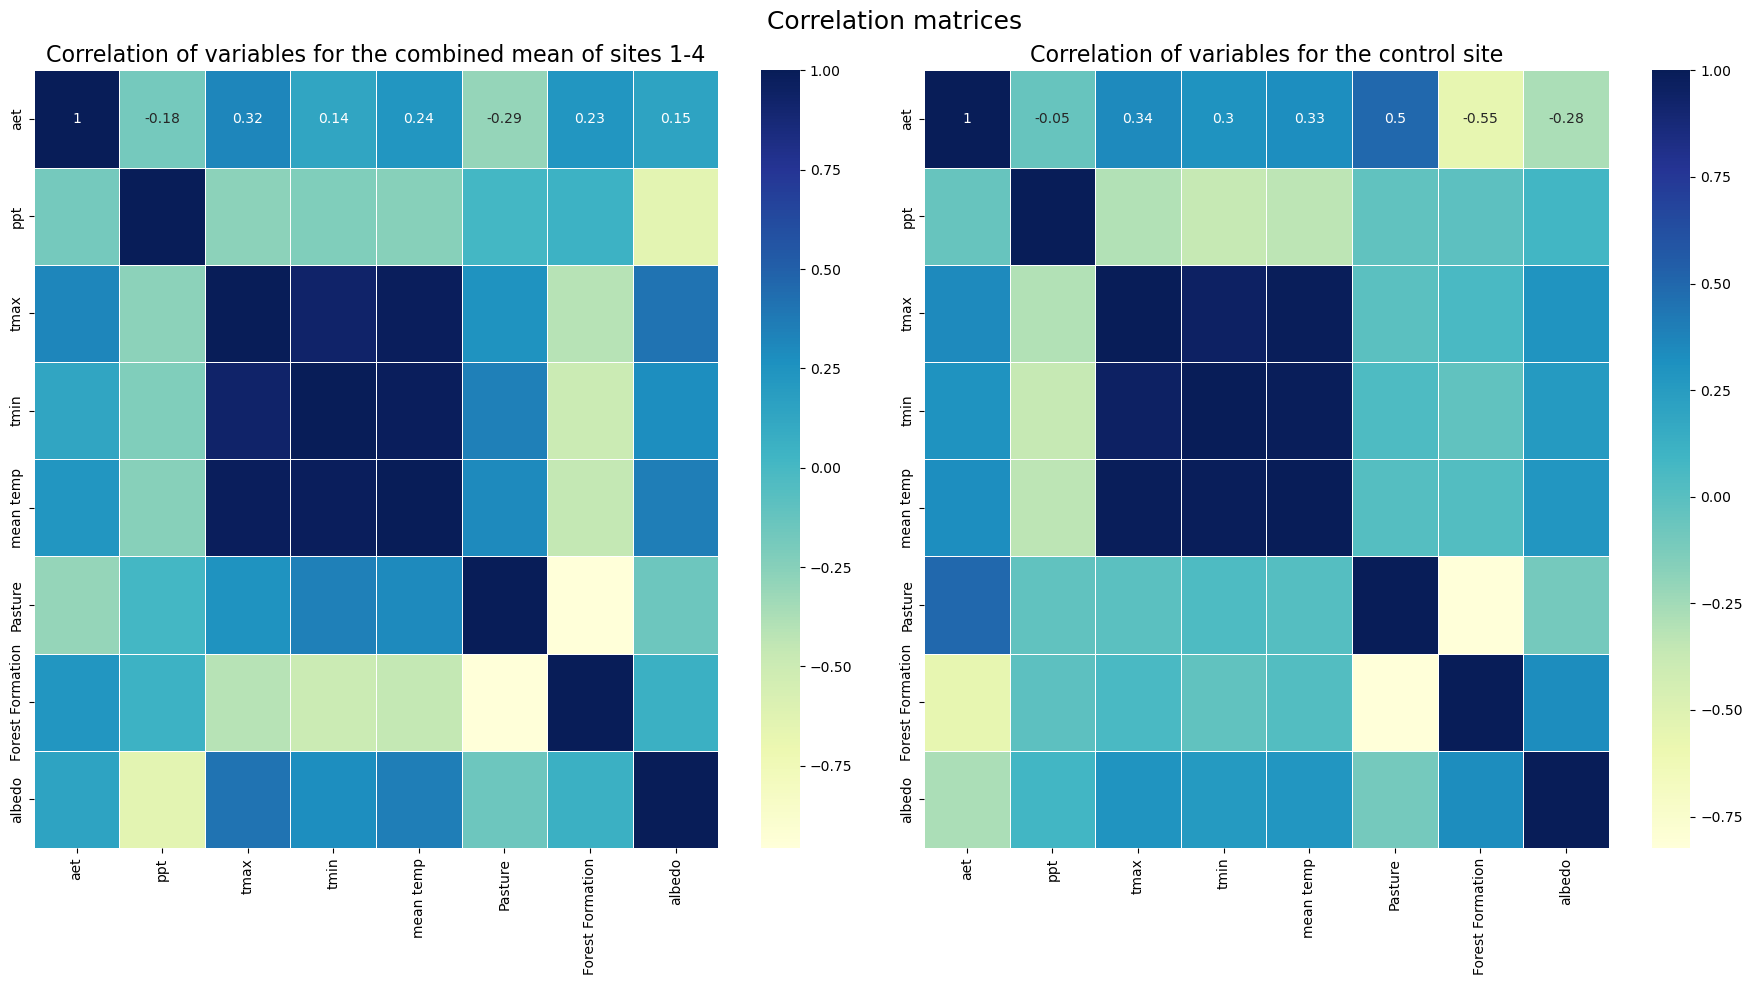

In [17]:
#combine sites 1 to 4 and obtain the mean to create a site 1-4 combined correlation matrix 
dataframes = [combined_df1, combined_df2, combined_df3, combined_df4]

# Store selected columns from each dataframe
selected_dataframes1_4 = []

# Go through columns of each df
for df in dataframes:
    selected_dataframes1_4.append(df[['aet', 'ppt', 'tmax', 'tmin', 'mean temp', 'Pasture', 'Forest Formation', 'albedo']])

# Concatenate the selected dataframes into one
combined_df_1_4 = pd.concat(selected_dataframes1_4)

# Calculate the mean and standard deviation for each variable across the dataframes
mean_across_dataframes1_4 = combined_df_1_4.groupby(level=0).mean()
SD_across_dataframes1_4 = combined_df_1_4.groupby(level=0).std()

# Pivot the comabine dataframe to create a correlation matrix
correlation_matrix1_4 = mean_across_dataframes1_4.corr() #sites 1-4

#plot mean of sites 1-4 and control site
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Correlation matrices', fontsize=18) 

#plot heatmap
S1_ax = sb.heatmap(correlation_matrix1_4, cmap='YlGnBu', linewidths=0.5, annot=True,  ax=ax[0])
S2_ax = sb.heatmap(combined_dfCS.corr(), cmap='YlGnBu', linewidths=0.5, annot=True, ax=ax[1])

#set axis
S1_ax.set_title('Correlation of variables for the combined mean of sites 1-4', fontsize=16)
S2_ax.set_title('Correlation of variables for the control site', fontsize=16)
plt.savefig(f'correlation_heatmap_mean_of_all_sites.png', bbox_inches='tight', dpi=100)

#plot
plt.tight_layout()
plt.show()

## Calculating the yearly mean difference compared to the mean of the reference period of 1985-1999

The following code calculates the yearly mean for each of the climate variables for the period of 2000-2022. Yearly means were compared to the mean of the reference period, 1985-1999 to determine the yearly mean difference. Yearly mean difference of climate variables and forest were plotted for comparison

Calculate the mean for 1985-1999 and then the yearly means for years 2000-2022 and then determine the difference:

In [18]:
# Calculate the mean for 1985-1999 and then the yearly means for years 2000-2022

#Site 1
S1_85_99 = Site_1.loc['1985-01': '1999-12']
S1_mean_85_99 = S1_85_99[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].mean()
S1_yr_mean = Site_1.loc['2000-01': ]
S1_yr_mean = S1_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].groupby('time').mean()
S1_yr_mean = S1_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').mean()
S1_yr_std = S1_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').std()


#Site 2
S2_85_99 = Site_2.loc['1985-01': '1999-12']
S2_mean_85_99 = S2_85_99[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].mean()
S2_yr_mean = Site_2.loc['2000-01': ]
S2_yr_mean = S2_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].groupby('time').mean()
S2_yr_mean = S2_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').mean()
S2_yr_std = S2_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').std()

#Site 3

S3_85_99 = Site_3.loc['1985-01': '1999-12']
S3_mean_85_99 = S3_85_99[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].mean()
S3_yr_mean = Site_3.loc['2000-01': ]
S3_yr_mean = S3_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].groupby('time').mean()
S3_yr_mean = S3_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').mean()
S3_yr_std = S3_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').std()

#Site 4
S4_85_99 = Site_4.loc['1985-01': '1999-12']
S4_mean_85_99 = S4_85_99[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].mean()
S4_yr_mean = Site_4.loc['2000-01': ]
S4_yr_mean = S4_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].groupby('time').mean()
S4_yr_mean = S4_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').mean()
S4_yr_std = S4_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').std()

#Control site
CS_85_99 = Control_site.loc['1985-01': '1999-12']
CS_mean_85_99 = CS_85_99[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].mean()
CS_yr_mean = Control_site.loc['2000-01': ]
CS_yr_mean = CS_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].groupby('time').mean()
CS_yr_mean = CS_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').mean()
CS_yr_std = S2_yr_mean[['tmin', 'tmax', 'mean temp', 'ppt', 'aet']].resample('1Y').std()


In [19]:
#Calculate the difference in yearly means compared to the mean of 1985-1999
yearly_mean_dfs = [S1_yr_mean, S2_yr_mean, S3_yr_mean, S4_yr_mean, CS_yr_mean]
mean_85_99_dfs = [S1_mean_85_99, S2_mean_85_99, S3_mean_85_99, S4_mean_85_99, CS_mean_85_99]
site_names = ['Site_1', 'Site_2', 'Site_3', 'Site_4', 'Control_site']

# Calculate and assign the differences for each site
for i in range(len(yearly_mean_dfs)):
    for column in ['tmin', 'tmax', 'mean temp', 'ppt', 'aet']:
        yearly_mean_dfs[i][f'{column}_mean_diff'] = yearly_mean_dfs[i][column] - mean_85_99_dfs[i][column]

In [20]:
#drop columns with absolute data
S1_mean_diff = S1_yr_mean.drop(['tmin', 'tmax', 'mean temp', 'ppt', 'aet'], axis = 1)
S2_mean_diff = S2_yr_mean.drop(['tmin', 'tmax', 'mean temp', 'ppt', 'aet'], axis = 1)
S3_mean_diff = S3_yr_mean.drop(['tmin', 'tmax', 'mean temp', 'ppt', 'aet'], axis = 1)
S4_mean_diff = S4_yr_mean.drop(['tmin', 'tmax', 'mean temp', 'ppt', 'aet'], axis = 1)
CS_mean_diff = CS_yr_mean.drop(['tmin', 'tmax', 'mean temp', 'ppt', 'aet'], axis = 1)

#save yearly mean difference datasets to csv
S1_mean_diff.to_csv('S1_mean_diff.csv')
S2_mean_diff.to_csv('S2_mean_diff.csv')
S3_mean_diff.to_csv('S3_mean_diff.csv')
S4_mean_diff.to_csv('S4_mean_diff.csv')
CS_mean_diff.to_csv('CS_mean_diff.csv')

In [21]:
#Concatenate the dataframes and find the combined yearly mean for each variable 

dataframes = [S1_mean_diff, S2_mean_diff, S3_mean_diff, S4_mean_diff]

# Concatenate the dataframes along the rows
S1_4_mean_df = pd.concat(dataframes)

# Calculate the mean and standard deviation for each variable across the dataframes
S1_4_mean_climate_df = S1_4_mean_df.groupby(level=0).mean()
S1_4_SD_climate_df = S1_4_mean_df.groupby(level=0).std()

Manipulate the mean difference forest datasets to extract the mean difference in forest cover:

In [22]:
#read the mean difference in forest percentage data
S1_forest = pd.read_csv('vegetation_analysis_mean_diff_Sample Site 1.csv')
S2_forest = pd.read_csv('vegetation_analysis_mean_diff_Sample Site 2.csv')
S3_forest = pd.read_csv('vegetation_analysis_mean_diff_Sample Site 3.csv')
S4_forest = pd.read_csv('vegetation_analysis_mean_diff_Sample Site 4.csv')
CS_forest = pd.read_csv('vegetation_analysis_mean_diff_Control Site.csv')

In [23]:
#locate the column representing mean difference in forest percentage from the dataset
S1_forest = S1_forest.iloc[:, 0]
S2_forest = S2_forest.iloc[:, 0]
S3_forest = S3_forest.iloc[:, 0]
S4_forest = S4_forest.iloc[:, 0]
CS_forest = CS_forest.iloc[:, 0]

In [24]:
#convert to a dataframe
S1_forest = pd.DataFrame(S1_forest)
S2_forest = pd.DataFrame(S2_forest)
S3_forest = pd.DataFrame(S3_forest)
S4_forest = pd.DataFrame(S4_forest)
CS_forest = pd.DataFrame(CS_forest)

In [25]:
#Concatenate the dataframes and find the combined yearly mean for mean difference in forest 
forest_dataframes = [S1_forest, S2_forest, S3_forest, S4_forest]

# Concatenate the dataframes along the rows
combined_forest = pd.concat(forest_dataframes)

# Calculate the mean for each variable across the dataframes
S1_4_mean_forest = combined_forest.groupby(level=0).mean()
S1_4_SD_forest = combined_forest.groupby(level=0).std()

Combined the forest and climate dataframes:

In [26]:
#reset the index of climate data
S1_4_mean_climate_df = S1_4_mean_climate_df.reset_index()
CS_mean_diff = CS_mean_diff.reset_index()

#combine the climate and forest datasets
S1_4_forest_cli = S1_4_mean_climate_df.join(S1_4_mean_forest)
CS_forest_cli = CS_forest.join(CS_mean_diff)

print(S1_4_forest_cli)
print(CS_forest_cli)

         time  tmin_mean_diff  tmax_mean_diff  mean temp_mean_diff  \
0  2000-12-31       -0.091121        0.053311            -0.018905   
1  2001-12-31        0.078432        0.204081             0.141255   
2  2002-12-31        0.339776        0.448775             0.394275   
3  2003-12-31        0.111619        0.237605             0.174611   
4  2004-12-31        0.177437        0.300090             0.238763   
5  2005-12-31        0.351925        0.456061             0.403993   
6  2006-12-31        0.091444        0.225046             0.158245   
7  2007-12-31        0.103057        0.274997             0.189027   
8  2008-12-31       -0.051552        0.085803             0.017125   
9  2009-12-31        0.333975        0.314127             0.324051   
10 2010-12-31        0.680232        0.785139             0.732685   
11 2011-12-31        0.219811        0.287232             0.253521   
12 2012-12-31        0.260794        0.277366             0.269080   
13 2013-12-31       

In [27]:
#Set the date to year only
S1_4_forest_cli['time'] = S1_4_forest_cli['time'].dt.to_period('Y')
CS_forest_cli['time'] = CS_forest_cli['time'].dt.to_period('Y')

Plot the mean difference for forest and climate data:

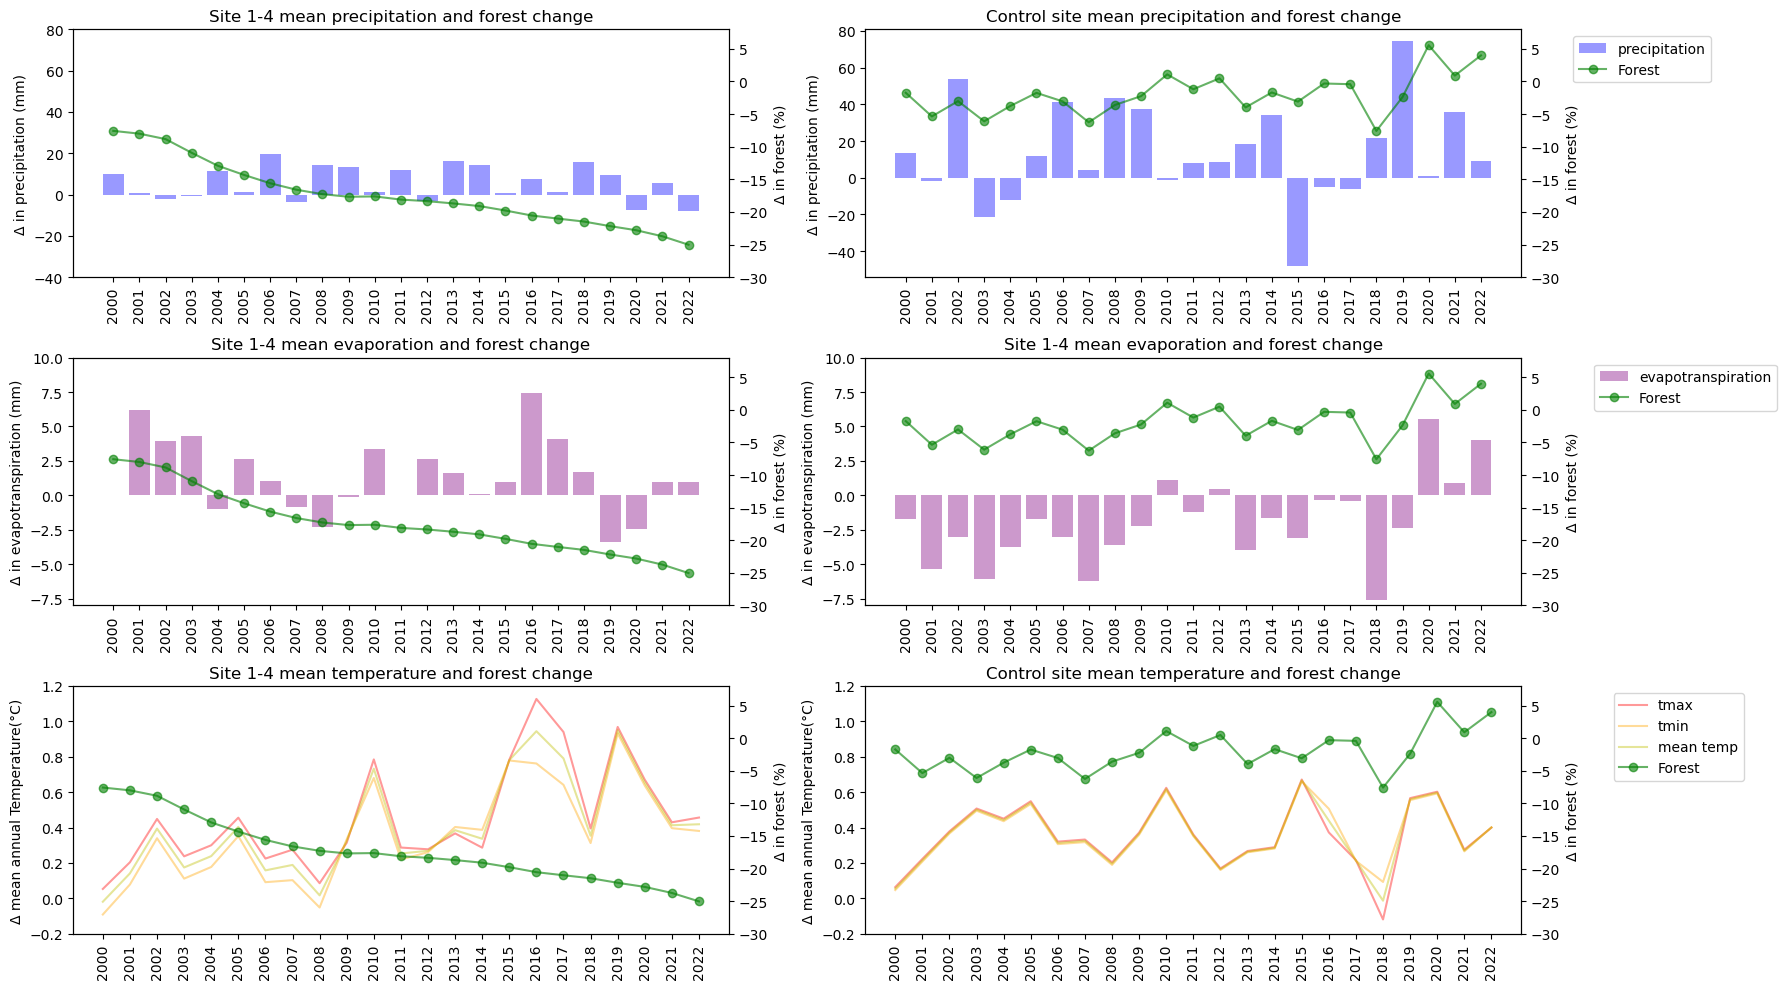

In [28]:
# Plot data in subplots
fig, axs = plt.subplots(3, 2, figsize=(18, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1) 

for i, ax in enumerate(axs.flat):
    if i == 0:
        # Plot the 'ppt_mean_diff' on primary y axis for mean of sites 1-4
        ax.bar(S1_4_forest_cli.index, S1_4_forest_cli['ppt_mean_diff'], color='b', alpha=0.4, label='precipitation')
        ax.set_ylabel('Δ in precipitation (mm)')
        ax.set_ylim(-40, 80)
        ax.set_title('Site 1-4 mean precipitation and forest change')

        # plot forest on the secondary y axis using column index for mean of sites 1-4
        ax2 = ax.twinx()
        column_index = 6  
        ax2.plot(S1_4_forest_cli.index, S1_4_forest_cli.iloc[:, column_index], color='g', alpha=0.6, marker='o', label='Forest')
        ax2.set_ylabel('Δ in forest (%)')
        ax2.set_ylim(-30, 8)

        x = range(len(S1_4_forest_cli)) 
        x_labels = S1_4_forest_cli['time']
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)
       

    elif i == 1:
        # Plot the 'ppt_mean_diff' on primary y axis for control site
        ax.bar(CS_forest_cli.index, CS_forest_cli['ppt_mean_diff'], color='b', alpha=0.4, label='precipitation')
        ax.set_ylabel('Δ in precipitation (mm)')

        # plot forest on the secondary y axis using column index for control site
        ax2 = ax.twinx()
        column_index = 6  
        ax2.plot(CS_forest_cli.index, CS_forest_cli.iloc[:, column_index], color='g', alpha=0.6, marker='o', label='Forest')
        ax2.set_ylabel('Δ in forest (%)')
        ax2.set_ylim(-30, 8)
        ax.set_title('Control site mean precipitation and forest change')

        #plot legend
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(1.3,1))
        
        x = range(len(CS_forest_cli))  
        x_labels = CS_forest_cli['time']
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)
    
    elif i == 2:
        # Plot the 'aet_mean_diff' on primary y axis for mean of sites 1-4
        ax.bar(S1_4_forest_cli.index, S1_4_forest_cli['aet_mean_diff'], color='purple', alpha=0.4, label='evapotranspiration')
        ax.set_ylabel('Δ in evapotranspiration (mm)')
        ax.set_title('Site 1-4 mean evaporation and forest change')
        ax.set_ylim(-8, 10)

        # plot forest on the secondary y axis using column index for mean of sites 1-4
        ax2 = ax.twinx()
        column_index = 6
        ax2.plot(S1_4_forest_cli.index, S1_4_forest_cli.iloc[:, column_index], color='g', alpha=0.6, marker='o', label='Forest')
        ax2.set_ylabel('Δ in forest (%)')
        ax2.set_ylim(-30, 8)

        x = range(len(S1_4_forest_cli)) 
        x_labels = S1_4_forest_cli['time']
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)

    elif i == 3:
        # Plot the 'ppt_mean_diff' on primary y axis for control sites
        ax.bar(CS_forest_cli.index, CS_forest_cli['aet_mean_diff'], color='purple', alpha=0.4, label='evapotranspiration')
        ax.set_ylabel('Δ in evapotranspiration (mm)')
        ax.set_title('Site 1-4 mean evaporation and forest change')
        ax.set_ylim(-8, 10)

        # plot forest on the secondary y axis using column index for control sites
        ax2 = ax.twinx()
        column_index = 6  
        ax2.plot(CS_forest_cli.index, CS_forest_cli.iloc[:, column_index], color='g', alpha=0.6, marker='o', label='Forest')
        ax2.set_ylabel('Δ in forest (%)')
        ax2.set_ylim(-30, 8)

        #plot legend
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(1.4,1))

        x = range(len(CS_forest_cli))  
        x_labels = CS_forest_cli['time']
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)

    elif i == 4:
        # Plot the 'mean difference in min, max and mean temperature on primary y axis for mean of sites 1-4
        columns_to_plot = ['tmax_mean_diff', 'tmin_mean_diff', 'mean temp_mean_diff']
        colors = ['r', 'orange', 'y']
        labels = ['tmax', 'tmin', 'mean temp']
        for column, color, label in zip(columns_to_plot, colors, labels):
            ax.plot(S1_4_forest_cli.index, S1_4_forest_cli[column], color=color, alpha=0.4, label=label)
        ax.set_ylim(-0.2, 1.2)
        ax.set_ylabel('Δ mean annual Temperature(°C)')
        ax.set_title('Site 1-4 mean temperature and forest change')
        
        # plot forest on the secondary y axis using column index for mean of sites 1-4
        ax2 = ax.twinx()
        column_index = 6  
        ax2.plot(S1_4_forest_cli.index, S1_4_forest_cli.iloc[:, column_index], color='g', alpha=0.6, marker='o', label='Forest')
        ax2.set_ylabel('Δ in forest (%)')
        ax2.set_ylim(-30, 8)

        x = range(len(S1_4_forest_cli))
        x_labels = S1_4_forest_cli['time']
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)
    elif i == 5:
        # Plot the 'mean difference in min, max and mean temperature on primary y axis for control site
        columns_to_plot = ['tmax_mean_diff', 'tmin_mean_diff', 'mean temp_mean_diff']
        colors = ['r', 'orange', 'y']
        labels = ['tmax', 'tmin', 'mean temp']

        for column, color, label in zip(columns_to_plot, colors, labels):
            ax.plot(CS_forest_cli.index, CS_forest_cli[column], color=color, alpha=0.4, label=label)
        ax.set_ylabel('Δ mean annual Temperature(°C)')
        ax.set_title('Control site mean temperature and forest change')
        ax.set_ylim(-0.2, 1.2)
        
        # plot forest on the secondary y axis using column index for control sites
        ax2 = ax.twinx()
        column_index = 6 
        ax2.plot(CS_forest_cli.index, CS_forest_cli.iloc[:, column_index], color='g', alpha=0.6, marker='o', label='Forest')
        ax2.set_ylabel('Δ in forest (%)')
        ax2.set_ylim(-30, 8)

        #plot legend
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(1.35,1))

        x = range(len(CS_forest_cli))
        x_labels = CS_forest_cli['time']
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)

plt.tight_layout()

#save to png
plt.savefig(f'mean_difference_climate_and_forest_ds_2000_2022_all_sites.png', bbox_inches='tight', dpi=100)

plt.show()